In [16]:
df = pd.read_csv('/kaggle/input/carbon/co2_daily_mlo.csv')
df

,Year,Month,Day,Decimal_Date,Concentration
0,1974,8,1,1974.5808,329.59
1,1974,8,2,1974.5836,329.69
2,1974,8,3,1974.5863,329.79
3,1974,8,4,1974.5890,330.23
4,1974,8,6,1974.5945,329.77
...,...,...,...,...,...
15603,2025,6,17,2025.4575,428.04
15604,2025,6,18,2025.4603,428.04
15605,2025,6,19,2025.4630,429.33
15606,2025,6,21,2025.4685,430.26


In [17]:
df = df.drop('Decimal_Date', axis=1)
df

,Year,Month,Day,Concentration
0,1974,8,1,329.59
1,1974,8,2,329.69
2,1974,8,3,329.79
3,1974,8,4,330.23
4,1974,8,6,329.77
...,...,...,...,...
15603,2025,6,17,428.04
15604,2025,6,18,428.04
15605,2025,6,19,429.33
15606,2025,6,21,430.26


18:34:37 - cmdstanpy - INFO - Chain [1] start processing
18:34:47 - cmdstanpy - INFO - Chain [1] done processing


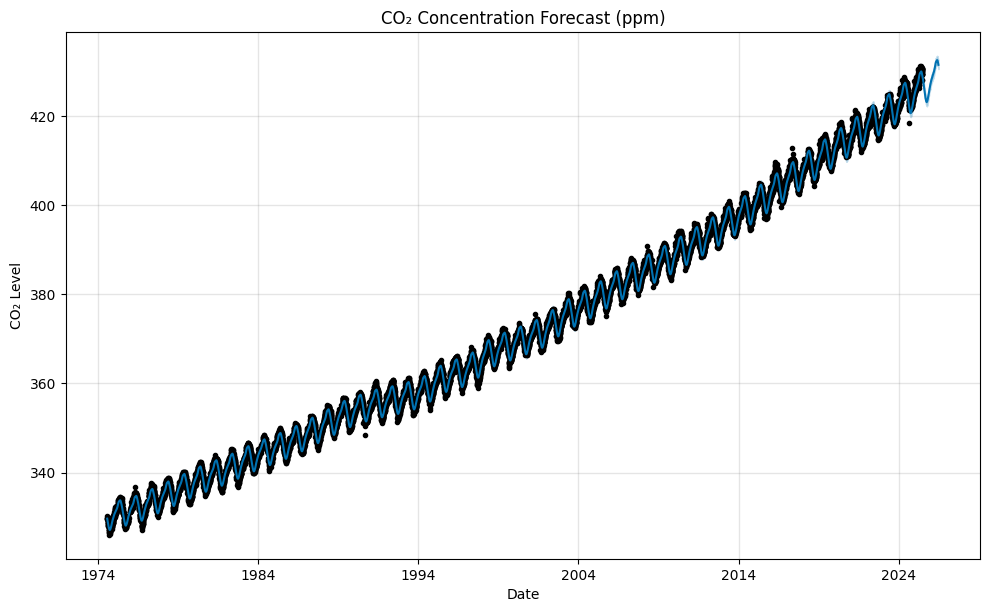

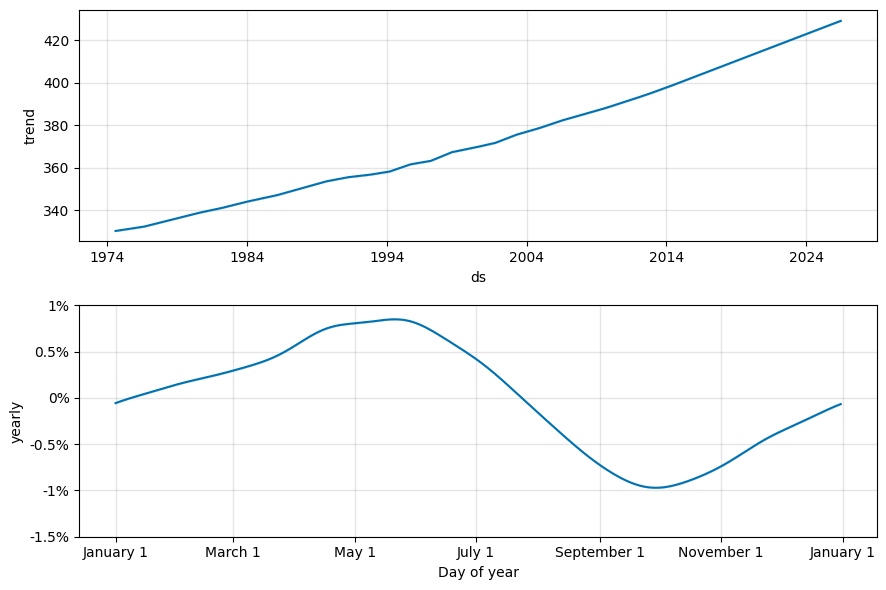

       Year  Month  Day  Concentration         ds        yhat  yhat_lower  \
15968   NaN    NaN  NaN            NaN 2026-06-18  431.630746  430.686736   
15969   NaN    NaN  NaN            NaN 2026-06-19  431.579275  430.747178   
15970   NaN    NaN  NaN            NaN 2026-06-20  431.527627  430.703440   
15971   NaN    NaN  NaN            NaN 2026-06-21  431.475781  430.560685   
15972   NaN    NaN  NaN            NaN 2026-06-22  431.423697  430.446488   

       yhat_upper  
15968  432.538907  
15969  432.457920  
15970  432.479509  
15971  432.330212  
15972  432.293714  


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [19]:
df_prophet = df.copy()
df_prophet['ds'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df_prophet['y'] = df['Concentration']

# 3. Initialize and Fit Model
model = Prophet(
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)
model.fit(df_prophet[['ds', 'y']])  # Only these two columns needed

# 4. Make Future Predictions (Next 365 days)
future = model.make_future_dataframe(periods=365, freq='D')
forecast = model.predict(future)

# 5. Visualize Results
fig1 = model.plot(forecast)
plt.title("CO₂ Concentration Forecast (ppm)")
plt.xlabel("Date")
plt.ylabel("CO₂ Level")
plt.show()

# 6. Show Trend and Seasonality
fig2 = model.plot_components(forecast)
plt.show()

# (Optional) Merge Forecast with Original Structure
forecast_merged = pd.merge(
    df,
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']],
    left_on=pd.to_datetime(df[['Year', 'Month', 'Day']]),
    right_on='ds',
    how='right'
)
print(forecast_merged.tail())

In [22]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# 1. Load your 7-day data
data = {
    'Day': [1, 2, 3, 4, 5, 6, 7],
    'Concentration': [420, 422, 421, 423, 425, 424, 426]
}

def predict(data):
        df = pd.DataFrame(data)
        
        # 2. Feature Engineering
        df['Day_sin'] = np.sin(2 * np.pi * df['Day']/7)
        df['Day_cos'] = np.cos(2 * np.pi * df['Day']/7)
        df['Lag_1'] = df['Concentration'].shift(1)
        df = df.dropna()  # Remove the first row with NaN
        
        # 3. Train model
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        X = df[['Day', 'Day_sin', 'Day_cos', 'Lag_1']]
        y = df['Concentration']
        model.fit(X, y)
        
        # 4. Prepare future days DataFrame
        future_days = pd.DataFrame({
            'Day': range(8, 15),
            'Day_sin': np.sin(2 * np.pi * np.arange(8, 15)/7),
            'Day_cos': np.cos(2 * np.pi * np.arange(8, 15)/7)
        })
        
        # 5. Recursive prediction with lag updates
        predictions = []
        last_known = df['Concentration'].iloc[-1]  # Last observed value
        
        for i in range(len(future_days)):
            # Prepare current day features
            current_features = future_days.iloc[i].copy()
            current_features['Lag_1'] = last_known
            
            # Predict and store
            pred = model.predict([current_features[['Day', 'Day_sin', 'Day_cos', 'Lag_1']]])[0]
            predictions.append(pred)
            last_known = pred  # Update for next iteration
        
        # Add predictions to DataFrame
        return predictions


pred = predict(data)
print(pred)


[424.0, 423.86, 423.7, 424.46, 424.79, 424.71, 425.01]


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does